# Assignment solution on the 1st dataset (9 to 10 steps of rapid walking)

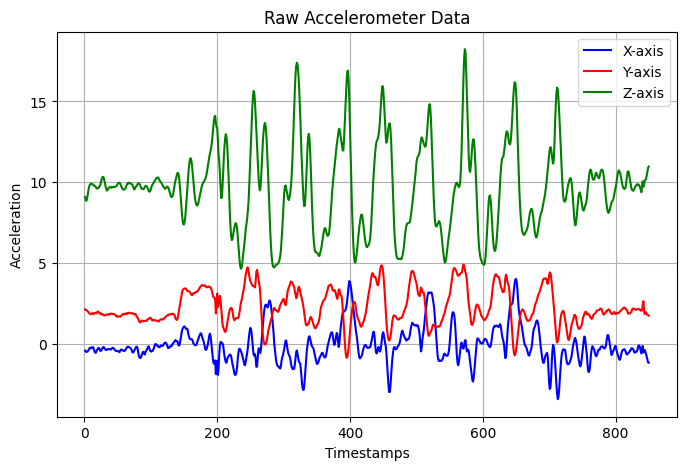

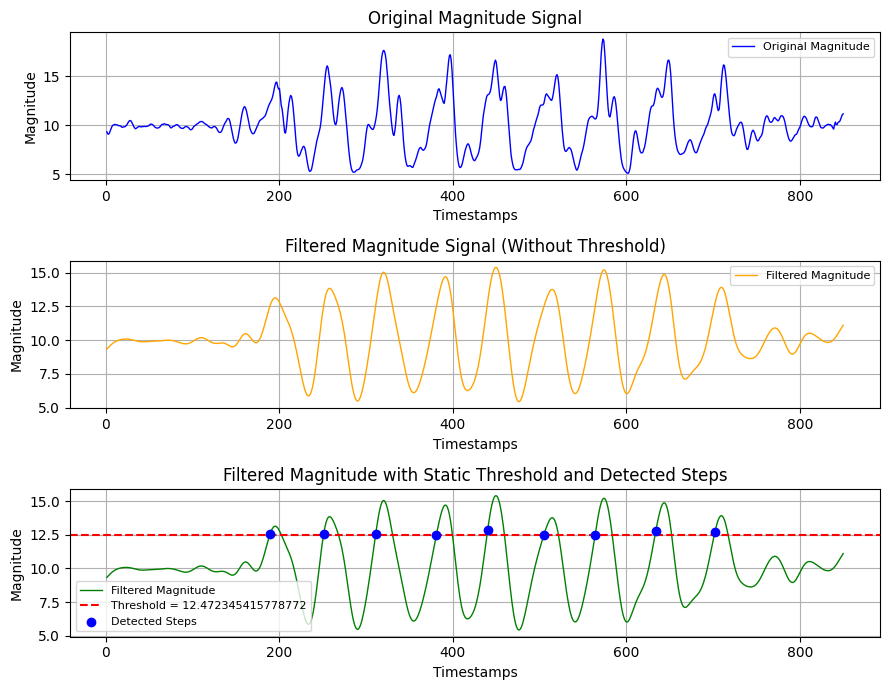

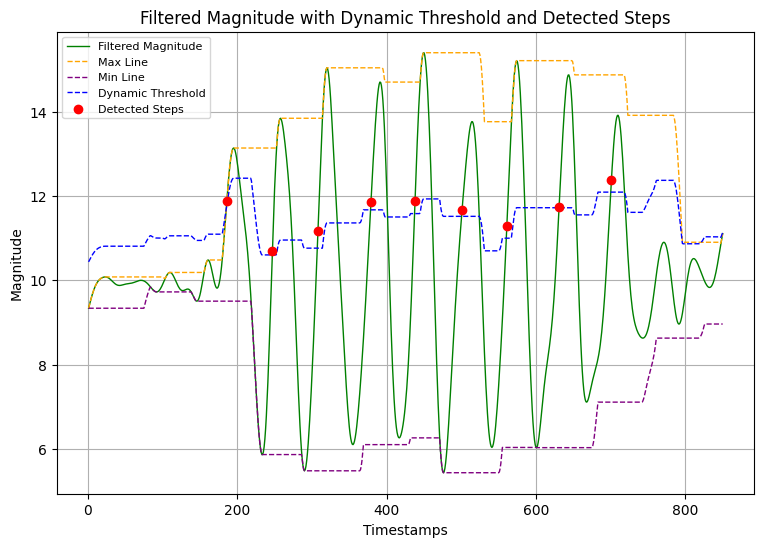

Number of steps detected (static threshold): 9
Number of steps detected (dynamic threshold): 9


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt

# Reading CSV files generated from MATLAB
def read_data(filename):
    data = pd.read_csv(filename, header=None, names=["timestamp", "x", "y", "z"])
    timestamps = data["timestamp"].to_numpy()
    x_array = data["x"].to_numpy()
    y_array = data["y"].to_numpy()
    z_array = data["z"].to_numpy()
    return timestamps, x_array, y_array, z_array

# Calculating the magnitude of vector
def calculate_magnitude(x_arr, y_arr, z_arr):
    return np.sqrt(x_arr**2 + y_arr**2 + z_arr**2)

# Low-pass-filter IIR Butterworth
def low_pass_filter(data, cutoff=3, fs=85, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Static threshold-based step counting
def count_steps_with_threshold(filtered_magnitude, threshold):
    steps = 0
    above_threshold = False
    step_indices = []

    for i, value in enumerate(filtered_magnitude):
        if value > threshold and not above_threshold:
            steps += 1
            above_threshold = True
            step_indices.append(i)
        elif value <= threshold and above_threshold:
            above_threshold = False

    return steps, step_indices

# Enhanced step counting using dynamic threshold with margin
def count_steps_with_dynamic_rise(timestamps, filtered_magnitude, window_size=75, margin=0):
    steps = 0
    step_indices = []
    max_line = []
    min_line = []
    dynamic_threshold = []
    above_threshold = False

    for i in range(len(filtered_magnitude)):
        if i < window_size:
            window = filtered_magnitude[:i + 1]
        else:
            window = filtered_magnitude[i - window_size + 1:i + 1]

        max_val = np.max(window)
        min_val = np.min(window)

        max_line.append(max_val)
        min_line.append(min_val)

        threshold = (max_val + min_val) / 2 + margin
        dynamic_threshold.append(threshold)

        if filtered_magnitude[i] > threshold and not above_threshold:
            steps += 1
            step_indices.append(i)
            above_threshold = True
        elif filtered_magnitude[i] <= threshold:
            above_threshold = False

    return steps, step_indices, max_line, min_line, dynamic_threshold

# Plotting raw accelerometer data
def plot_accelerometer_data(timestamps, x_array, y_array, z_array):
    plt.figure(figsize=(8, 5))
    plt.plot(timestamps, x_array, label="X-axis", color="blue")
    plt.plot(timestamps, y_array, label="Y-axis", color="red")
    plt.plot(timestamps, z_array, label="Z-axis", color="green")
    plt.title("Raw Accelerometer Data")
    plt.xlabel("Timestamps")
    plt.ylabel("Acceleration")
    plt.legend()
    plt.grid()
    plt.show()


# Plotting magnitude signal with static threshold and detected steps
def plot_magnitude_with_steps(timestamps, magnitude_signal, filtered_magnitude, threshold, step_indices):
    plt.figure(figsize=(9, 7))

    # Original magnitude
    plt.subplot(3, 1, 1)
    plt.plot(timestamps, magnitude_signal, color="blue", linewidth=1.0, label="Original Magnitude")
    plt.title("Original Magnitude Signal")
    plt.xlabel("Timestamps")
    plt.ylabel("Magnitude")
    plt.legend(fontsize=8)
    plt.grid()

    # Filtered magnitude without threshold
    plt.subplot(3, 1, 2)
    plt.plot(timestamps, filtered_magnitude, color="orange", linewidth=1.0, label="Filtered Magnitude")
    plt.title("Filtered Magnitude Signal (Without Threshold)")
    plt.xlabel("Timestamps")
    plt.ylabel("Magnitude")
    plt.legend(fontsize=8)
    plt.grid()

    # Filtered magnitude with static threshold and detected steps
    plt.subplot(3, 1, 3)
    plt.plot(timestamps, filtered_magnitude, color="green", linewidth=1.0, label="Filtered Magnitude")
    plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    plt.scatter(
        [timestamps[i] for i in step_indices],
        [filtered_magnitude[i] for i in step_indices],
        color="blue", label="Detected Steps", zorder=5
    )
    plt.title("Filtered Magnitude with Static Threshold and Detected Steps")
    plt.xlabel("Timestamps")
    plt.ylabel("Magnitude")
    plt.legend(fontsize=8)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot magnitude signal with dynamic threshold and detected steps
def plot_magnitude_with_dynamic_rise(timestamps, filtered_magnitude, step_indices, max_line, min_line, dynamic_threshold):
    plt.figure(figsize=(9, 6))

    # Plot filtered magnitude
    plt.plot(timestamps, filtered_magnitude, label="Filtered Magnitude", color="green", linewidth=1.0)

    # Plot max and min lines
    plt.plot(timestamps, max_line, label="Max Line", color="orange", linestyle="--", linewidth=1.0)
    plt.plot(timestamps, min_line, label="Min Line", color="purple", linestyle="--", linewidth=1.0)

    # Plot dynamic threshold
    plt.plot(timestamps, dynamic_threshold, label="Dynamic Threshold", color="blue", linestyle="--", linewidth=1.0)

    # Plot detected steps
    plt.scatter(
        [timestamps[i] for i in step_indices],
        [filtered_magnitude[i] for i in step_indices],
        color="red", label="Detected Steps", zorder=5
    )

    plt.title("Filtered Magnitude with Dynamic Threshold and Detected Steps")
    plt.xlabel("Timestamps")
    plt.ylabel("Magnitude")
    plt.legend(fontsize=8)
    plt.grid()
    plt.show()

# Main sequential flow
def main():
    # Step 1: Reading data from the CSV file
    filename = "10stepsFast-horizontal_20241126_232927.csv"
    timestamps, x_array, y_array, z_array = read_data(filename)

    # Step 2: Plotting raw accelerometer data
    plot_accelerometer_data(timestamps, x_array, y_array, z_array)

    # Step 3: Calculating the magnitude signal
    magnitude_signal = calculate_magnitude(x_array, y_array, z_array)

    # Step 4: Applying a low-pass filter to the magnitude signal
    filtered_magnitude = low_pass_filter(magnitude_signal, cutoff=3, fs=85, order=4)

    # Step 5: Count steps using the static threshold
    k = 1.0  # Adjust this value as required
    mean_val = np.mean(filtered_magnitude)
    std_val = np.std(filtered_magnitude)
    static_threshold = mean_val + k * std_val
    steps_static, step_indices_static = count_steps_with_threshold(filtered_magnitude, static_threshold)

    # Step 6: Plotting magnitude signal with static threshold and detected steps
    plot_magnitude_with_steps(timestamps, magnitude_signal, filtered_magnitude, static_threshold, step_indices_static)

    # Step 7: Counting steps using the dynamic threshold
    margin = 1.1  # this value to be adjusted as needed
    steps_dynamic, step_indices_dynamic, max_line, min_line, dynamic_threshold = count_steps_with_dynamic_rise(
        timestamps, filtered_magnitude, window_size=75, margin=margin
    )

    # Step 8: Plot magnitude signal with dynamic threshold and detected steps
    plot_magnitude_with_dynamic_rise(timestamps, filtered_magnitude, step_indices_dynamic, max_line, min_line, dynamic_threshold)

    # Step 9: Print the number of steps detected
    print(f"Number of steps detected (static threshold): {steps_static}")
    print(f"Number of steps detected (dynamic threshold): {steps_dynamic}")

# Execute the sequential flow
main()


# Solution on the 2nd Dataset (12 or 13 steps of walking + jumping in 15.65 time span)

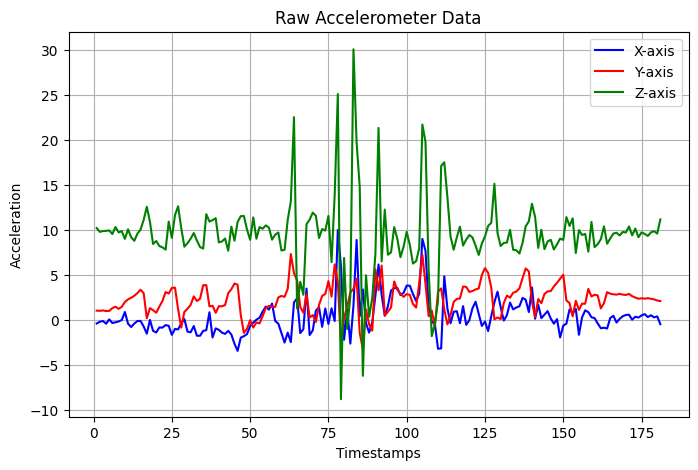

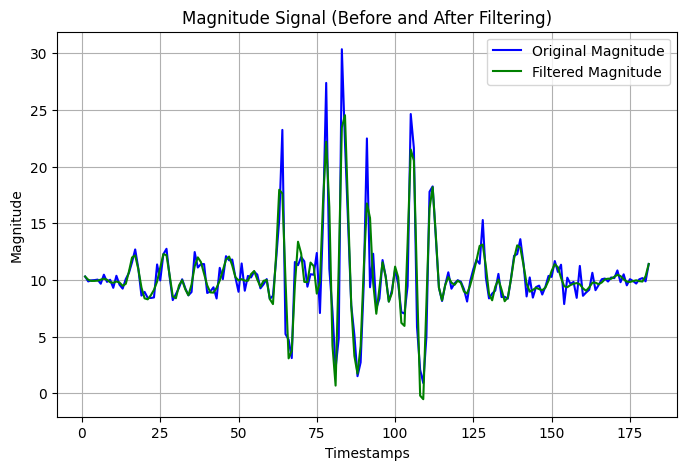

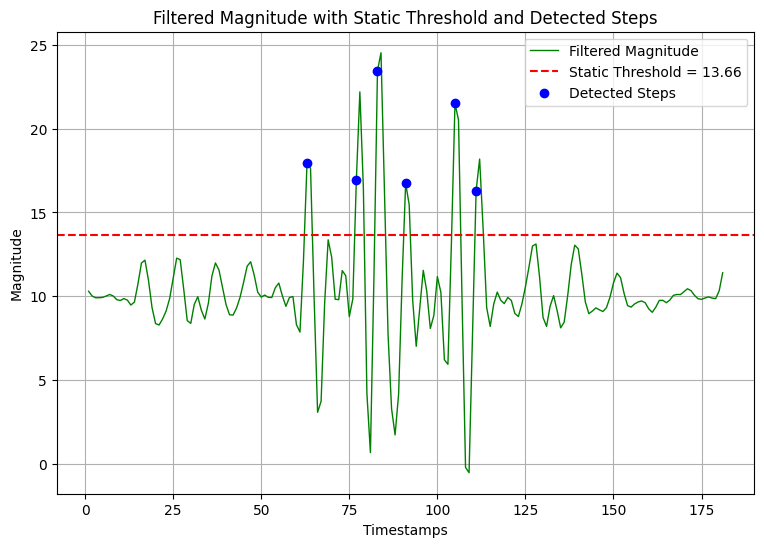

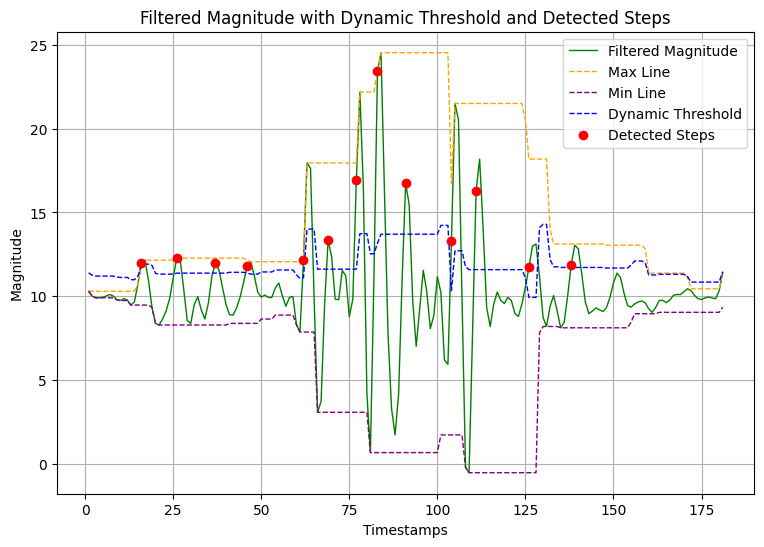

Number of steps detected using static threshold: 6
Number of steps detected using dynamic threshold: 13
Actual number of steps is 12 or 13


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt

# Reading CSV files generated from MATLAB
def read_data(filename):
    data = pd.read_csv(filename, header=None, names=["timestamp", "x", "y", "z"])
    timestamps = data["timestamp"].to_numpy()
    x_array = data["x"].to_numpy()
    y_array = data["y"].to_numpy()
    z_array = data["z"].to_numpy()
    return timestamps, x_array, y_array, z_array

# Calculating the magnitude of vector
def calculate_magnitude(x_arr, y_arr, z_arr):
    return np.sqrt(x_arr**2 + y_arr**2 + z_arr**2)

# Low-pass-filter IIR Butterworth
def low_pass_filter(data, cutoff=5, fs=12, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Enhanced step counting using dynamic threshold with margin
def count_steps_with_dynamic_rise(timestamps, filtered_magnitude, window_size=20, margin=0):
    steps = 0
    step_indices = []
    max_line = []
    min_line = []
    dynamic_threshold = []
    above_threshold = False  # Track if the signal is above the threshold

    for i in range(len(filtered_magnitude)):
        # Calculate rolling max and min
        if i < window_size:
            window = filtered_magnitude[:i + 1]
        else:
            window = filtered_magnitude[i - window_size + 1:i + 1]

        max_val = np.max(window)
        min_val = np.min(window)

        max_line.append(max_val)
        min_line.append(min_val)

        # Dynamic threshold as the midpoint plus margin
        threshold = (max_val + min_val) / 2 + margin
        dynamic_threshold.append(threshold)

        # Step detection: detect rise above the threshold
        if filtered_magnitude[i] > threshold and not above_threshold:
            steps += 1
            step_indices.append(i)
            above_threshold = True
        elif filtered_magnitude[i] <= threshold:
            above_threshold = False

    return steps, step_indices, max_line, min_line, dynamic_threshold

# Static Threshold Step Counting
def count_steps_with_static_threshold(filtered_magnitude, threshold):
    steps = 0
    above_threshold = False
    step_indices = []  # Store indices of detected steps

    for i, value in enumerate(filtered_magnitude):
        if value > threshold and not above_threshold:
            steps += 1
            step_indices.append(i)
            above_threshold = True
        elif value <= threshold:
            above_threshold = False

    return steps, step_indices

# Plotting static threshold results
def plot_static_threshold(timestamps, filtered_magnitude, threshold, step_indices):
    plt.figure(figsize=(9, 6))

    # Plotting filtered magnitude
    plt.plot(timestamps, filtered_magnitude, label="Filtered Magnitude", color="green", linewidth=1.0)

    # Plotting static threshold line
    plt.axhline(y=threshold, color="red", linestyle="--", label=f"Static Threshold = {threshold:.2f}")

    # Plotting detected steps
    plt.scatter(
        [timestamps[i] for i in step_indices],
        [filtered_magnitude[i] for i in step_indices],
        color="blue", label="Detected Steps", zorder=5
    )

    plt.title("Filtered Magnitude with Static Threshold and Detected Steps")
    plt.xlabel("Timestamps")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid()
    plt.show()

# Plot raw accelerometer data
def plot_accelerometer_data(timestamps, x_array, y_array, z_array):
    plt.figure(figsize=(8, 5))
    plt.plot(timestamps, x_array, label="X-axis", color="blue")
    plt.plot(timestamps, y_array, label="Y-axis", color="red")
    plt.plot(timestamps, z_array, label="Z-axis", color="green")
    plt.title("Raw Accelerometer Data")
    plt.xlabel("Timestamps")
    plt.ylabel("Acceleration")
    plt.legend()
    plt.grid()
    plt.show()

# Plot magnitude signal (before and after filtering)
def plot_magnitude_signals(timestamps, magnitude_signal, filtered_magnitude):
    plt.figure(figsize=(8, 5))

    # Original magnitude
    plt.plot(timestamps, magnitude_signal, label="Original Magnitude", color="blue")
    # Filtered magnitude
    plt.plot(timestamps, filtered_magnitude, label="Filtered Magnitude", color="green")

    plt.title("Magnitude Signal (Before and After Filtering)")
    plt.xlabel("Timestamps")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid()
    plt.show()

# Plot magnitude signal with dynamic threshold and detected steps
def plot_magnitude_with_dynamic_rise(timestamps, filtered_magnitude, step_indices, max_line, min_line, dynamic_threshold):
    plt.figure(figsize=(9, 6))

    # Plot filtered magnitude
    plt.plot(timestamps, filtered_magnitude, label="Filtered Magnitude", color="green", linewidth=1.0)

    # Plot max and min lines
    plt.plot(timestamps, max_line, label="Max Line", color="orange", linestyle="--", linewidth=1.0)
    plt.plot(timestamps, min_line, label="Min Line", color="purple", linestyle="--", linewidth=1.0)

    # Plot dynamic threshold
    plt.plot(timestamps, dynamic_threshold, label="Dynamic Threshold", color="blue", linestyle="--", linewidth=1.0)

    # Plot detected steps
    plt.scatter(
        [timestamps[i] for i in step_indices],
        [filtered_magnitude[i] for i in step_indices],
        color="red", label="Detected Steps", zorder=5
    )

    plt.title("Filtered Magnitude with Dynamic Threshold and Detected Steps")
    plt.xlabel("Timestamps")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid()
    plt.show()

# Main sequential flow
def main():
    # Step 1: Read data from the CSV file
    filename = "12step-walk+jump-15-65.csv"
    timestamps, x_array, y_array, z_array = read_data(filename)

    # Step 2: Plot raw accelerometer data
    plot_accelerometer_data(timestamps, x_array, y_array, z_array)

    # Step 3: Calculate the magnitude signal
    magnitude_signal = calculate_magnitude(x_array, y_array, z_array)

    # Step 4: Apply a low-pass filter to the magnitude signal
    filtered_magnitude = low_pass_filter(magnitude_signal, cutoff=3, fs=12, order=7)

    # Step 5: Plot magnitude signals (before and after filtering)
    plot_magnitude_signals(timestamps, magnitude_signal, filtered_magnitude)

    # Step 6: Count steps using the static threshold
    k = 1  # Coefficient for standard deviation
    static_threshold = np.mean(filtered_magnitude) + k * np.std(filtered_magnitude)
    static_steps, static_step_indices = count_steps_with_static_threshold(filtered_magnitude, static_threshold)

    # Step 7: Plot the filtered magnitude signal with the static threshold
    plot_static_threshold(timestamps, filtered_magnitude, static_threshold, static_step_indices)



    # Step 9: Count steps using the enhanced step counting algorithm with margin
    margin = 1.1  # Adjust this value to push the threshold up or down
    steps_detected, step_indices, max_line, min_line, dynamic_threshold = count_steps_with_dynamic_rise(
        timestamps, filtered_magnitude, window_size=20, margin=margin
    )

    # Step 10: Plot the magnitude signal with dynamic threshold and detected steps
    plot_magnitude_with_dynamic_rise(timestamps, filtered_magnitude, step_indices, max_line, min_line, dynamic_threshold)

    # Step 8: Print the number of steps detected with the static threshold
    print(f"Number of steps detected using static threshold: {static_steps}")

    # Step 11: Print the number of steps detected with the dynamic threshold
    print(f"Number of steps detected using dynamic threshold: {steps_detected}")

    print("Actual number of steps is 12 or 13")

# Execute the sequential flow
main()
